In [23]:
%matplotlib inline

import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns

So, the first thing that we want to do is a little background research into what we are getting ourselves into. It appears to be a dataset of 115 first year engineering undergrads participating in an expiriment. This expiriment is designed to track the activities of the participants during their sessions within an eductional suite.

It appears that the majority of the data exists within the `Data/Processes/` directory. This directory contains 6 sub-directories for each of the 6 sessions tracked. Within these `Session` folders. One of the first tasks is going to be to read in all of these data files, but before that, we must create labels for the header row. The headers are found in `features_info.txt`. 

In [24]:
header_list = ['session', 'student_id', 'exercise', 'activity', 'start_time', 
               'end_time', 'idle_time','mouse_wheel', 'mouse_wheel_click',
               'left_click','right_click','mouse_movement','keystroke']

In [26]:
allFiles = glob.glob('Data/Processes/*/*') 
frame = pd.DataFrame() 
list_ = [] 

for file_ in allFiles: 
    df = pd.read_csv(file_)
    df.columns = header_list
    list_.append(df)
frame = pd.concat(list_) 


In [60]:
frame

,session,student_id,exercise,activity,start_time,end_time,idle_time,mouse_wheel,mouse_wheel_click,left_click,right_click,mouse_movement,keystroke
0,1,1,Es,Aulaweb,2.10.2014 11:25:35,2.10.2014 11:25:42,218,0,0,4,0,397,0
1,1,1,Es,Blank,2.10.2014 11:25:43,2.10.2014 11:25:43,0,0,0,0,0,59,0
2,1,1,Es,Deeds,2.10.2014 11:25:44,2.10.2014 11:26:17,154117,6,0,8,0,1581,4
3,1,1,Es,Other,2.10.2014 11:26:18,2.10.2014 11:26:18,0,0,0,2,0,103,0
4,1,1,Es,Other,2.10.2014 11:26:19,2.10.2014 11:26:27,460,0,0,4,0,424,8
5,1,1,Es,Blank,2.10.2014 11:26:28,2.10.2014 11:26:28,0,0,0,1,0,93,0
6,1,1,Es,Deeds,2.10.2014 11:26:29,2.10.2014 11:26:29,0,0,0,1,0,75,0
7,1,1,Es,Aulaweb,2.10.2014 11:26:30,2.10.2014 11:26:33,0,0,0,2,0,238,0
8,1,1,Es,Deeds,2.10.2014 11:26:34,2.10.2014 11:26:41,4933,0,0,2,0,268,0
9,1,1,Es,Other,2.10.2014 11:26:42,2.10.2014 11:26:47,3212,0,0,4,0,275,2


In [28]:
frame.describe()

,session,student_id,idle_time,mouse_wheel,mouse_wheel_click,left_click,right_click,mouse_movement,keystroke
count,229798.000000,229798.000000,2.297980e+05,229798.000000,229798.000000,229798.000000,229798.000000,229798.000000,229798.000000
mean,3.695058,53.626233,-1.852064e+09,2.749741,0.005457,7.083112,0.336870,415.060222,6.294045
std,1.770348,31.542913,4.502500e+11,27.169832,0.223620,21.567963,3.020974,1273.675902,51.017414
min,1.000000,1.000000,-2.059092e+14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,27.000000,0.000000e+00,0.000000,0.000000,2.000000,0.000000,62.000000,0.000000
50%,4.000000,53.000000,8.000000e+01,0.000000,0.000000,2.000000,0.000000,138.000000,0.000000
75%,5.000000,81.000000,5.779000e+03,0.000000,0.000000,5.000000,0.000000,336.000000,0.000000
max,6.000000,115.000000,7.244736e+09,2904.000000,60.000000,1096.000000,168.000000,85949.000000,4754.000000


Whoops! Looks like the `session` and `student_id` columns are continuous. Let's go ahead and factorize those. Also, while we are at it, let's take a look at why data types each of the columns are. I am suspicious about the `start_time` and `end_time` features.

In [65]:
frame[['session','student_id']] = frame[['session','student_id']].astype('category')
frame['start_time'] = pd.to_datetime(frame['start_time'], format=' %d.%m.%Y %H:%M:%S')
frame['end_time'] = pd.to_datetime(frame['end_time'], format=' %d.%m.%Y %H:%M:%S')

print(frame.columns.to_series().groupby(frame.dtypes).groups)


{dtype('O'): ['exercise', 'activity'], category: ['session', 'student_id'], dtype('int64'): ['idle_time', 'mouse_wheel', 'mouse_wheel_click', 'left_click', 'right_click', 'mouse_movement', 'keystroke'], dtype('<M8[ns]'): ['start_time', 'end_time']}


In [66]:
frame.describe()

,idle_time,mouse_wheel,mouse_wheel_click,left_click,right_click,mouse_movement,keystroke
count,2.297980e+05,229798.000000,229798.000000,229798.000000,229798.000000,229798.000000,229798.000000
mean,-1.852064e+09,2.749741,0.005457,7.083112,0.336870,415.060222,6.294045
std,4.502500e+11,27.169832,0.223620,21.567963,3.020974,1273.675902,51.017414
min,-2.059092e+14,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000e+00,0.000000,0.000000,2.000000,0.000000,62.000000,0.000000
50%,8.000000e+01,0.000000,0.000000,2.000000,0.000000,138.000000,0.000000
75%,5.779000e+03,0.000000,0.000000,5.000000,0.000000,336.000000,0.000000
max,7.244736e+09,2904.000000,60.000000,1096.000000,168.000000,85949.000000,4754.000000


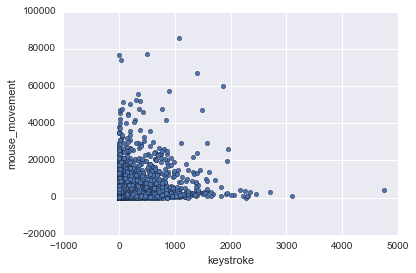

In [37]:
frame.plot(kind="scatter", x="keystroke", y="mouse_movement")

{dtype('O'): ['exercise', 'activity', 'start_time', 'end_time'],
 category: ['session', 'student_id'],
 dtype('int64'): ['idle_time',
  'mouse_wheel',
  'mouse_wheel_click',
  'left_click',
  'right_click',
  'mouse_movement',
  'keystroke']}